In [1]:
import xml.etree.ElementTree as ET
from lxml import etree
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import datetime

In [2]:
xml_data = '/Users/ryand/pyprojects/Data/apple_health_export/export.xml'

In [3]:
class apple_health(object):
    def __init__(self, xml_data_path):
        self.tree = etree.parse(xml_data_path)
        self.root = self.tree.getroot()
        self.records = []
        for i, element in enumerate(self.root):
            self.records.append(element.attrib)
        self.r_types = []
        self.analyze_types()
        
    def analyze_types(self):
        for i, record in enumerate(self.records):
            try:
                if record['type'] not in self.r_types:
                    self.r_types.append(record['type'])
                else:
                    pass
            except:
                pass
        
    def extract_type(self, r_type):
        r_type_list = []
        for i, record in enumerate(self.records):
            try:
                if record['type'] == r_type:
                    r_type_list.append(record)
            except:
                pass
        r_type_list_ = [dict(record) for record in r_type_list]
        df = pd.DataFrame(r_type_list_, columns = r_type_list_[0].keys())
        time_col = ['startDate','endDate']
        for col in time_col:
            df[col] = pd.to_datetime(df[col])
        try:
            df['value'] = df['value'].astype(float)
        except:
            pass
        return df
    

In [4]:
def format_dates(df):
    df['date'] = df['startDate'].map(lambda x: x.date())
    sub_df = df.groupby('date').sum().reset_index()
    sub_df['month'] = sub_df['date'].map(lambda x: x.month)
    sub_df['year'] = sub_df['date'].map(lambda x: x.year)
    sub_df['day_of_month'] = sub_df['date'].map(lambda x: x.day)
    return sub_df

In [15]:
my_data = apple_health(xml_data)
my_data.r_types

['HKQuantityTypeIdentifierHeight',
 'HKQuantityTypeIdentifierBodyMass',
 'HKQuantityTypeIdentifierHeartRate',
 'HKQuantityTypeIdentifierStepCount',
 'HKQuantityTypeIdentifierDistanceWalkingRunning',
 'HKQuantityTypeIdentifierBasalEnergyBurned',
 'HKQuantityTypeIdentifierActiveEnergyBurned',
 'HKQuantityTypeIdentifierFlightsClimbed',
 'HKQuantityTypeIdentifierNikeFuel',
 'HKQuantityTypeIdentifierAppleExerciseTime',
 'HKCategoryTypeIdentifierSleepAnalysis',
 'HKCategoryTypeIdentifierAppleStandHour',
 'HKCategoryTypeIdentifierMindfulSession']

In [16]:
df_ET = my_data.extract_type('HKQuantityTypeIdentifierAppleExerciseTime')
df_HR = my_data.extract_type('HKQuantityTypeIdentifierHeartRate')
df_SC = my_data.extract_type('HKQuantityTypeIdentifierStepCount')

# Analizing steps

In [17]:
watch_SC = df_SC[df_SC['sourceName'] == 'Ryan’s Apple\xa0Watch'].reset_index(inplace=False)
del watch_SC['index']
Haley_SC = df_SC[df_SC['sourceName'] == 'Haley'].reset_index(inplace=False)
del Haley_SC['index']

In [18]:
for i, startDate in enumerate(watch_SC['startDate']):
    try:
        endDate = watch_SC.loc[i-1, 'endDate']
        between = Haley_S[(Haley_SC['startDate'] > endDate)
                              & (Haley_SC['endDate'] < startDate)]
        if len(between) > 0:
            watch_SC = watch_SC.append(between)
    except:
        pass

In [19]:
watch_SC['cc'] = 1
watch_SC.groupby('sourceName').sum()[['cc']]

,cc
sourceName,
Ryan’s Apple Watch,76597


In [20]:
df = watch_SC

In [21]:
from datetime import timedelta

df['startDate_local'] = df['startDate'].map(lambda x: x - timedelta(hours=7))
df['date'] = df['startDate_local'].map(lambda x: x.date())

In [22]:
_SC = df.groupby('date').sum()[['value']].rename(columns={'value':'steps'})

# Analizing Heart Rate

In [23]:
df_HR['startDate_local'] = df_HR['startDate'].map(lambda x: x - timedelta(hours=7))
df_HR['date'] = df_HR['startDate_local'].map(lambda x: x.date())

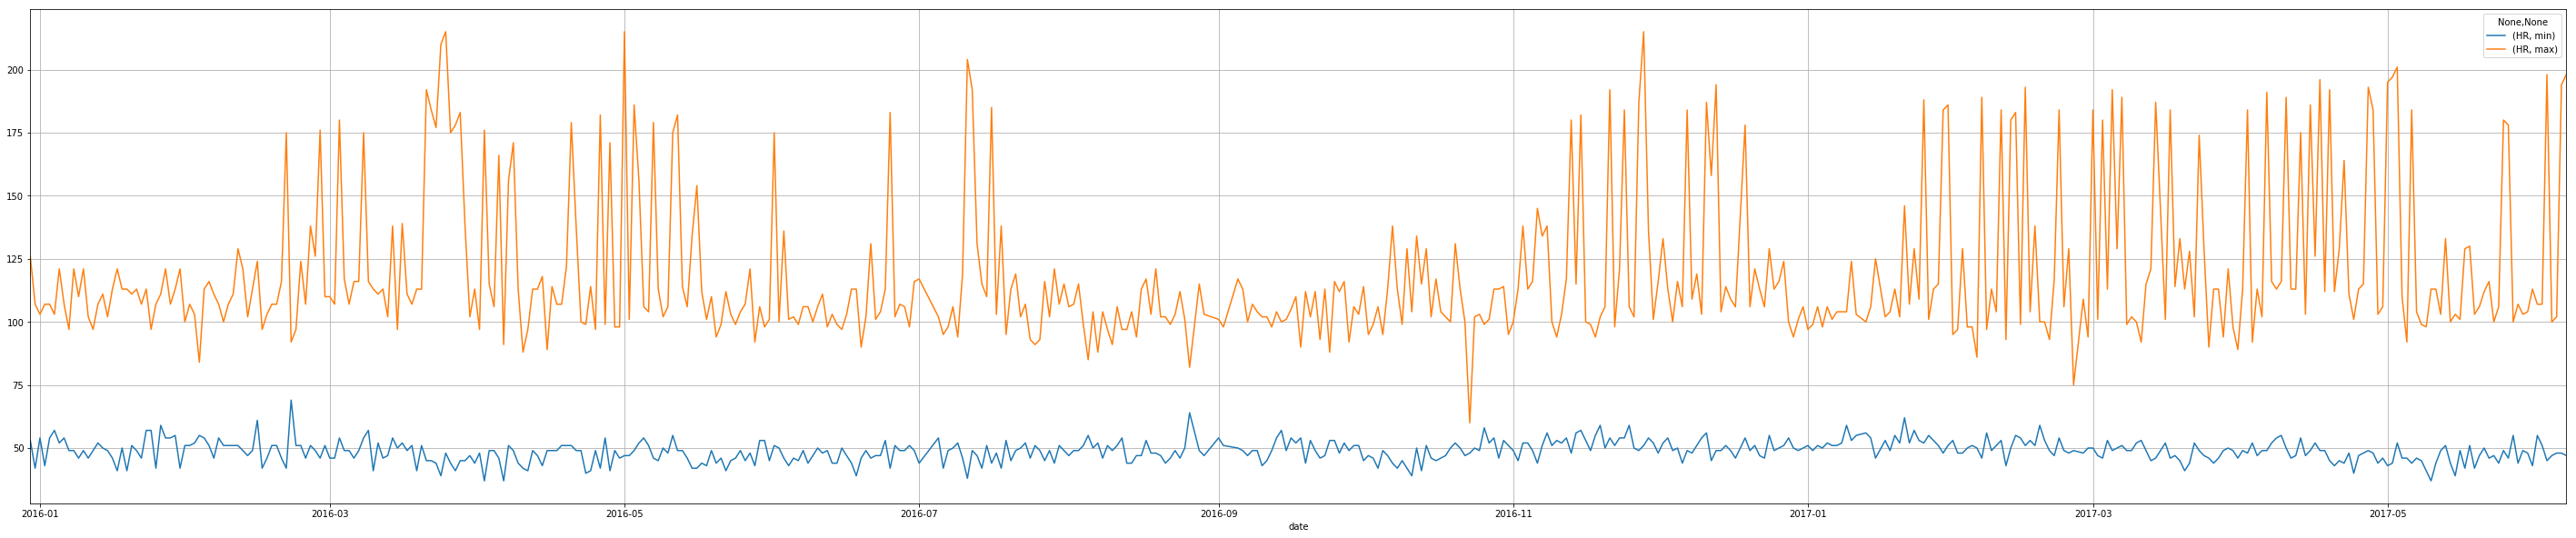

In [24]:
_HR = df_HR.groupby('date').agg({'value':['min','max']}).rename(columns={'value':'HR'})
_HR.plot(figsize=(50,10), grid=True)

In [16]:
_HR = df_HR.groupby('date').agg({'value':'describe'}).unstack(level=1)[[('value','25%'),('value','75%')]].rename(columns={'value':'HR'})

# Steps + Heart Rate

/Users/ryand/pyprojects/pyproj-venv3/lib/python3.6/site-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


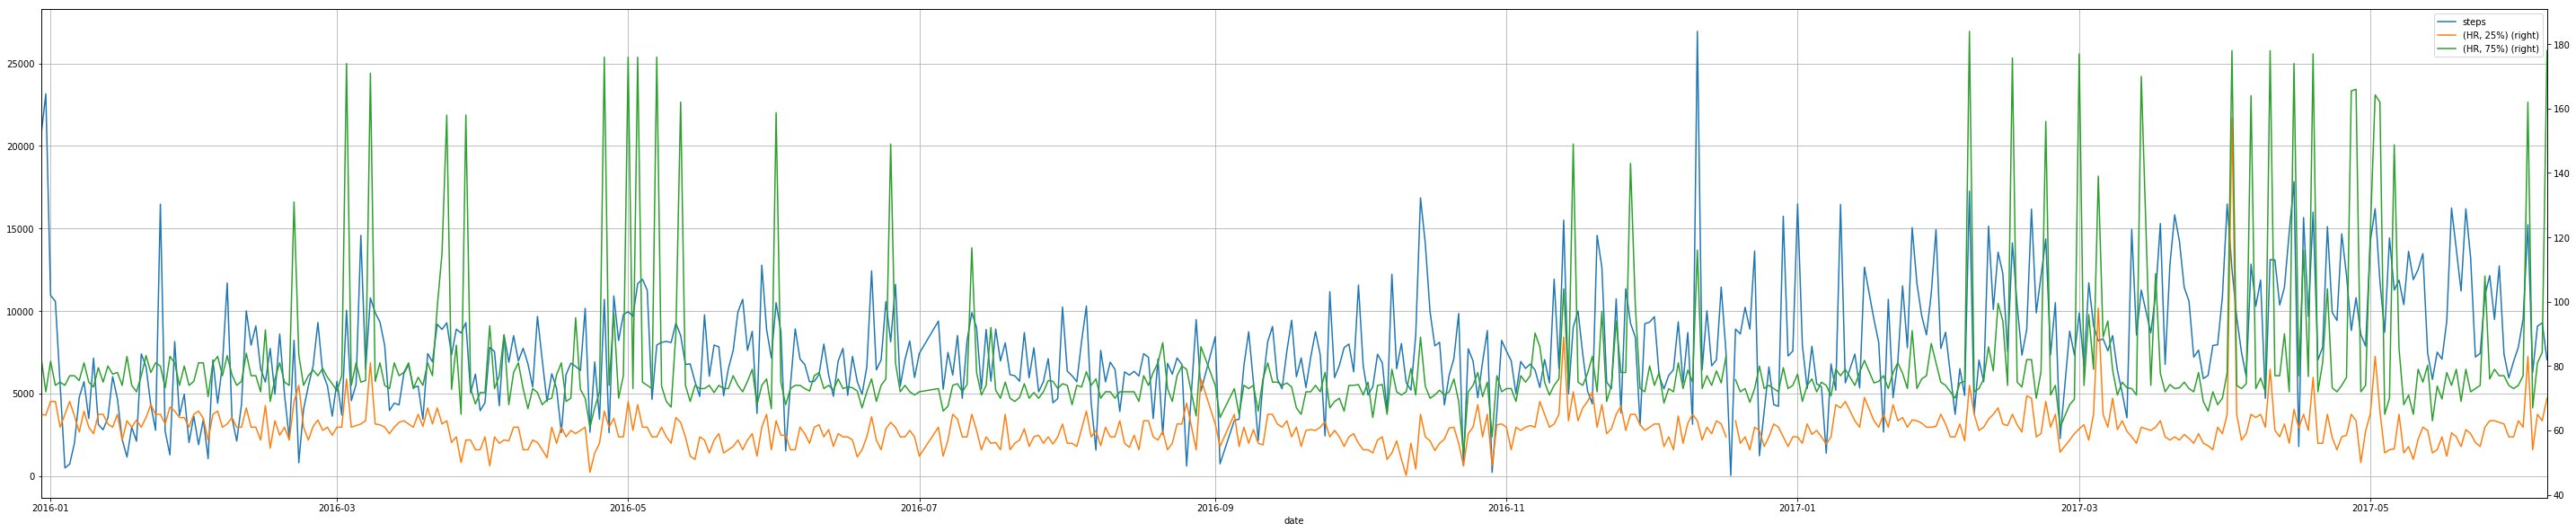

In [17]:
_SC.join(_HR).plot(figsize=(50,10), secondary_y=[('HR','25%'),('HR','75%')], grid=True)

# Sleep

In [209]:
df_S = my_data.extract_type('HKCategoryTypeIdentifierSleepAnalysis')

In [210]:
for x in ['startDate','endDate']:
    df_S[f'{x}_local'] = df_S[f'{x}'].map(lambda x: x - timedelta(hours=7))

In [211]:
# df_S = df_S[df_S['sourceName'] == 'Clock']
df_S = df_S.sort_values('startDate_local')
df_S = df_S.reset_index()
del df_S['index']

In [212]:
for x in range(20):
    count = 0
    for i, startDate in enumerate(df_S['startDate_local']):
        try:
            endDate = df_S.loc[i-1, 'endDate_local']
            if (startDate - timedelta(minutes=30)) < endDate:
                new_endDate = df_S.loc[i, 'endDate_local']
                df_S.loc[i-1, 'endDate_local'] = new_endDate
                df_S.loc[i, 'drop'] = True
                count += 1
        except:
            pass
    print(f'Pass {x} with {count}')
    count = 0
df_S = df_S[df_S['drop'] != True]
del df_S['drop']

Pass 0 with 265
Pass 1 with 265
Pass 2 with 265
Pass 3 with 265
Pass 4 with 265
Pass 5 with 265
Pass 6 with 265
Pass 7 with 265
Pass 8 with 265
Pass 9 with 265
Pass 10 with 265
Pass 11 with 265
Pass 12 with 265
Pass 13 with 265
Pass 14 with 265
Pass 15 with 265
Pass 16 with 265
Pass 17 with 265
Pass 18 with 265
Pass 19 with 265


In [213]:
df_S['duration'] = (df_S['endDate_local'] - df_S['startDate_local']).map(lambda x: x.seconds/3600)


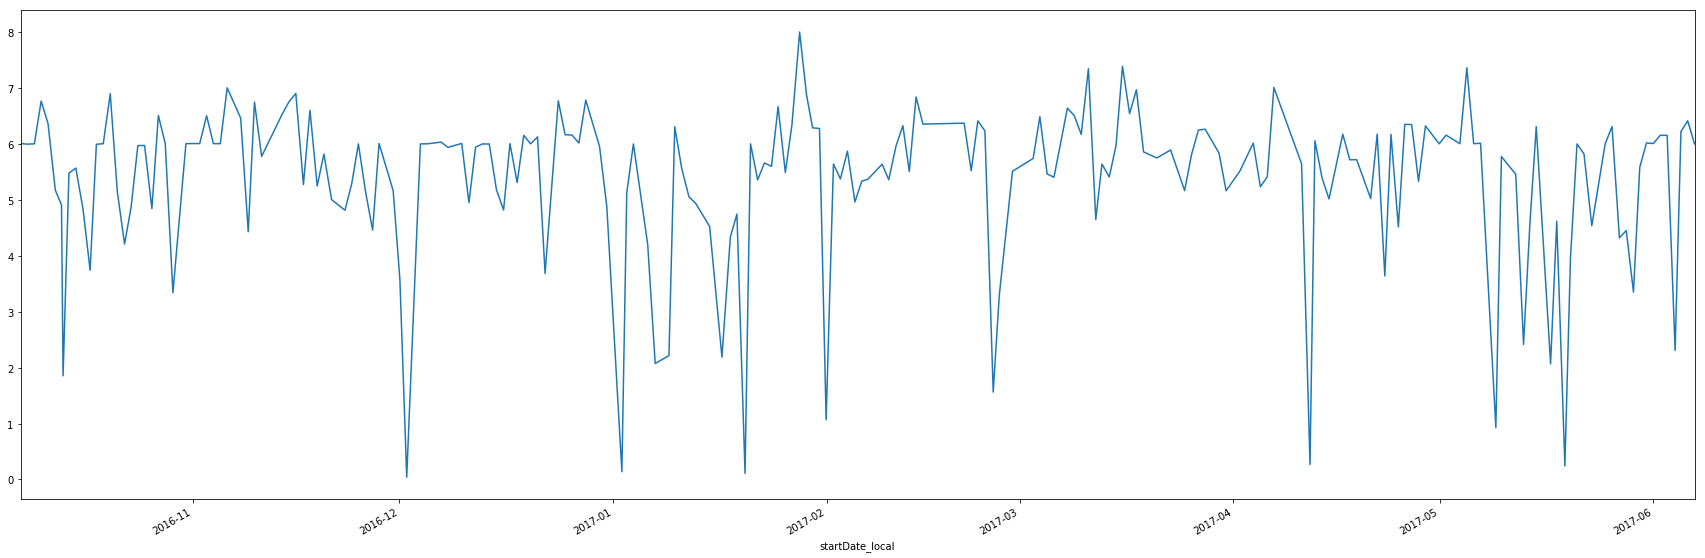

In [214]:
df_S = df_S.set_index('startDate_local')
df_S['duration'].plot(figsize=(30,10))

# Active Energy Burned

In [222]:
df_AE = my_data.extract_type('HKQuantityTypeIdentifierActiveEnergyBurned')

In [223]:
df_AE

,type,sourceName,sourceVersion,device,unit,creationDate,startDate,endDate,value
0,HKQuantityTypeIdentifierActiveEnergyBurned,Ryan’s Apple Watch,2.0.1,"<<HKDevice: 0x174c83980>, name:Apple Watch, ma...",kcal,2015-12-30 06:21:34 -0700,2015-12-30 12:17:13,2015-12-30 13:17:14,0.289
1,HKQuantityTypeIdentifierActiveEnergyBurned,Ryan’s Apple Watch,2.0.1,"<<HKDevice: 0x174c841a0>, name:Apple Watch, ma...",kcal,2015-12-30 06:21:34 -0700,2015-12-30 13:17:14,2015-12-30 13:18:15,1.152
2,HKQuantityTypeIdentifierActiveEnergyBurned,Ryan’s Apple Watch,2.0.1,"<<HKDevice: 0x174c84100>, name:Apple Watch, ma...",kcal,2015-12-30 06:21:34 -0700,2015-12-30 13:18:15,2015-12-30 13:19:16,0.059
3,HKQuantityTypeIdentifierActiveEnergyBurned,Ryan’s Apple Watch,2.0.1,"<<HKDevice: 0x174c84380>, name:Apple Watch, ma...",kcal,2015-12-30 06:21:34 -0700,2015-12-30 13:19:16,2015-12-30 13:20:17,0.006
4,HKQuantityTypeIdentifierActiveEnergyBurned,Ryan’s Apple Watch,2.0.1,"<<HKDevice: 0x174c84290>, name:Apple Watch, ma...",kcal,2015-12-30 06:21:34 -0700,2015-12-30 13:20:17,2015-12-30 13:21:19,0.281
5,HKQuantityTypeIdentifierActiveEnergyBurned,Ryan’s Apple Watch,2.0.1,"<<HKDevice: 0x174c84010>, name:Apple Watch, ma...",kcal,2015-12-30 06:22:36 -0700,2015-12-30 13:21:19,2015-12-30 13:21:59,0.096
6,HKQuantityTypeIdentifierActiveEnergyBurned,Ryan’s Apple Watch,2.0.1,"<<HKDevice: 0x174c84330>, name:Apple Watch, ma...",kcal,2015-12-30 06:24:24 -0700,2015-12-30 13:23:01,2015-12-30 13:24:02,0.190
7,HKQuantityTypeIdentifierActiveEnergyBurned,Ryan’s Apple Watch,2.0.1,"<<HKDevice: 0x174c84650>, name:Apple Watch, ma...",kcal,2015-12-30 06:25:24 -0700,2015-12-30 13:24:02,2015-12-30 13:25:03,0.166
8,HKQuantityTypeIdentifierActiveEnergyBurned,Ryan’s Apple Watch,2.0.1,"<<HKDevice: 0x174c83f70>, name:Apple Watch, ma...",kcal,2015-12-30 06:26:30 -0700,2015-12-30 13:25:03,2015-12-30 13:26:04,1.272
9,HKQuantityTypeIdentifierActiveEnergyBurned,Ryan’s Apple Watch,2.0.1,"<<HKDevice: 0x174c84a60>, name:Apple Watch, ma...",kcal,2015-12-30 06:27:43 -0700,2015-12-30 13:26:04,2015-12-30 13:26:15,0.042
